In [31]:
%pip install xgboost==1.4.2
%pip install tensorflow==2.8.0
%pip install torch==1.12.1
%pip install scikit-learn==1.1.2
%pip install coremltools
%pip install pandas
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Using cached xgboost-1.4.2.tar.gz (716 kB)
  ERROR: Command errored out with exit status 1:
   command: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/kw/m5bx8hkn2jx_drrsy015f98r0000gn/T/pip-install-odzmn9ut/xgboost_0266fba501f4470e95b375e42541cc9b/setup.py'"'"'; __file__='"'"'/private/var/folders/kw/m5bx8hkn2jx_drrsy015f98r0000gn/T/pip-install-odzmn9ut/xgboost_0266fba501f4470e95b375e42541cc9b/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/kw/m5bx8hkn2jx_drrsy015f98r0000gn/T/pip-wheel-ynmeb58v
       cwd: /private/var/folders/kw/m5bx8hkn2jx_drrsy015f9

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import coremltools as ct
import shap

Data Sample:
   AccelX_mean  AccelX_std  AccelX_min  AccelX_max  AccelY_mean  AccelY_std  \
0    -0.060629    0.266065    0.112402    0.729531     1.415190    0.891503   
1     0.392353    0.255408    0.211169   -1.985513     0.393849   -0.359277   
2     0.636916    0.047813    0.620049   -0.781715     2.377784   -1.128958   
3     0.433085    0.047757    0.293624    0.092829     2.328127   -1.188119   
4     0.594652   -0.231829    0.181070    1.121600     1.574508   -0.256928   

   AccelY_min  AccelY_max  AccelZ_mean  AccelZ_std  ...  Pace_min   Pace_max  \
0   17.919515   25.579102   -24.743555    0.367219  ...  0.921473   6.374429   
1   23.851038   27.033990   -15.321622    0.367219  ...  1.114268   4.027287   
2    6.200455   23.879474   -15.435166    0.367219  ...  3.582506  10.193016   
3   -3.631767   18.170063   -17.057446    0.367219  ...  3.758887  14.259961   
4   14.011055    7.320015   -25.777532    0.362024  ...  1.880728  16.063942   

   StepCount_mean  StepCount_st

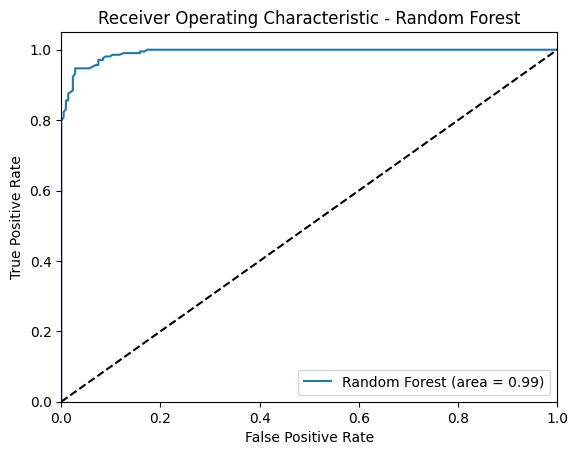

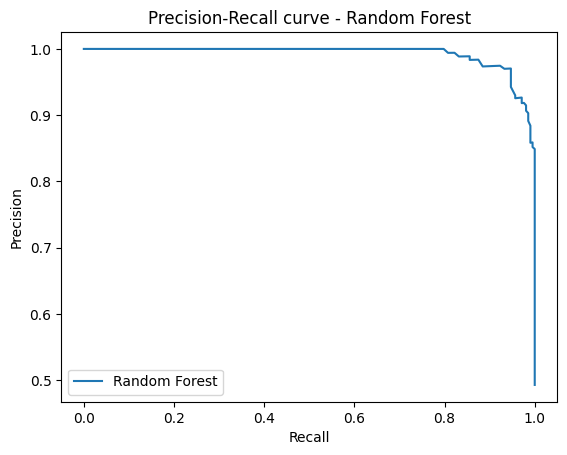

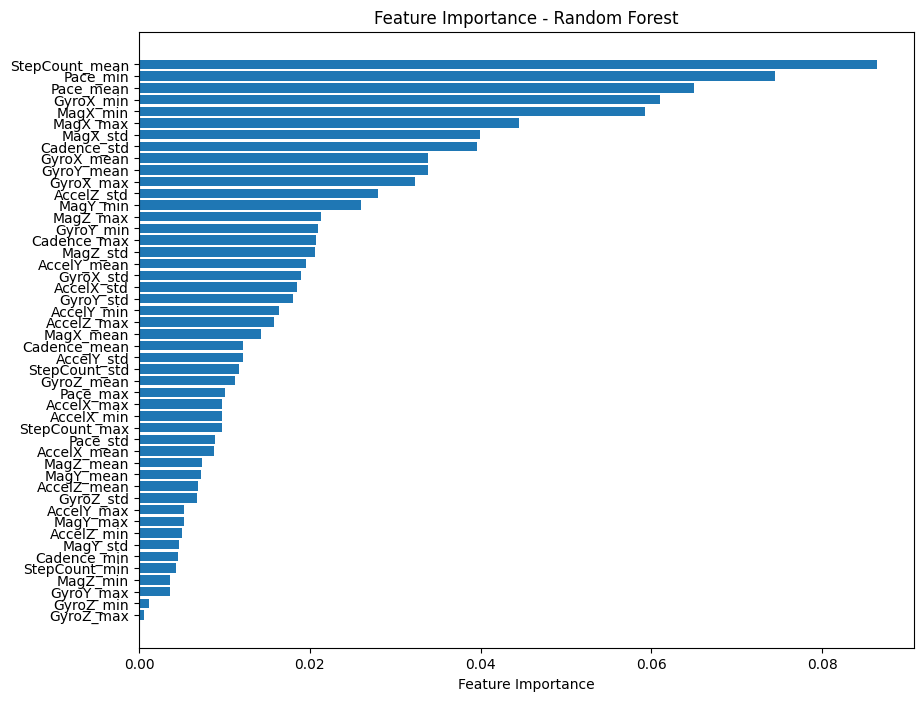

/Users/anthonyskyng-thow-hing/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


RandomForestClassifier model successfully converted to Core ML format.


In [3]:

# Define paths to the uploaded folders
basketball_path = '/Users/anthonyskyng-thow-hing/Downloads/Sports ml project/basketball'
soccer_path = '/Users/anthonyskyng-thow-hing/Downloads/Sports ml project/soccer'

# List files in the directories
basketball_files = os.listdir(basketball_path)
soccer_files = os.listdir(soccer_path)

# Function to load data, drop the 'Activity' column, split into intervals, and aggregate the data
def load_split_and_aggregate(file_path, interval=1, sample_rate=50):
    df = pd.read_csv(file_path)
    if 'Activity' in df.columns:
        df = df.drop(columns=['Activity'])

    rows_per_interval = interval * sample_rate

    aggregated_intervals = []
    num_intervals = len(df) // rows_per_interval
    for i in range(num_intervals):
        interval_df = df.iloc[i*rows_per_interval : (i+1)*rows_per_interval]
        agg_df = interval_df.agg(['mean', 'std', 'min', 'max']).T

        new_columns = [f'{col}_{stat}' for col in interval_df.columns for stat in ['mean', 'std', 'min', 'max']]

        agg_df.columns = ['mean', 'std', 'min', 'max']
        agg_df = agg_df.unstack().to_frame().T
        agg_df.columns = new_columns

        flattened = agg_df.values.flatten()
        aggregated_intervals.append(flattened)

    return aggregated_intervals, new_columns

# Initialize lists to store data, labels, and columns
X_data = []
y_data = []
columns = None

# Load, split, and aggregate all basketball files
for file in basketball_files:
    if file.endswith('.csv'):
        intervals, new_columns = load_split_and_aggregate(os.path.join(basketball_path, file))
        X_data.extend(intervals)
        y_data.extend([0] * len(intervals))
        if columns is None:
            columns = new_columns

# Load, split, and aggregate all soccer files
for file in soccer_files:
    if file.endswith('.csv'):
        intervals, new_columns = load_split_and_aggregate(os.path.join(soccer_path, file))
        X_data.extend(intervals)
        y_data.extend([1] * len(intervals))
        if columns is None:
            columns = new_columns

# Create the DataFrame with the correct column names
X = pd.DataFrame(X_data, columns=columns)
y = pd.Series(y_data)

print("Data Sample:")
print(X.head())

# Data preprocessing
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# Train and evaluate RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on the validation set
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred, output_dict=True)
val_cm = confusion_matrix(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

# Display validation results
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation ROC AUC: {val_roc_auc}")
print("Validation Classification Report:")
print(val_report)
print("Validation Confusion Matrix:")
print(val_cm)

# Test the model on the test set
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred, output_dict=True)
test_cm = confusion_matrix(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Display test results
print(f"Test Accuracy: {test_accuracy}")
print(f"Test ROC AUC: {test_roc_auc}")
print("Test Classification Report:")
print(test_report)
print("Test Confusion Matrix:")
print(test_cm)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label=f'Random Forest (area = {test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve - Random Forest')
plt.legend(loc="lower left")
plt.show()

# Feature importance
feature_importance = model.feature_importances_
sorted_idx = feature_importance.argsort()

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [columns[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Random Forest')
plt.show()

# Convert the RandomForestClassifier model to Core ML format
try:
    coreml_model = ct.converters.sklearn.convert(model)
    coreml_model.save('RandomForestClassifierIntervals.mlmodel')
    print("RandomForestClassifier model successfully converted to Core ML format.")
except Exception as e:
    print(f"Error converting RandomForestClassifier to Core ML format: {e}")
